# Modelo de Machine Learning

Una vez preparados los datos, se procede a buscar un modelo de Machine Learning de clasificación, que permita clasificar a un paciente como *hospitalizado* o *no hospitalizado*, teniendo en cuenta la información referente a sus antecedentes como paciente, las morbilidad asociadas, los antecedentes relacionados con la toma de la biopsia y complicaciones infecciosas.

Para ello, se plantean dos estrategias para esa busqueda. Por un lado, utilizar las 12 columnas de datos y, en una segunda estrategia, se considera la reducción de dimensionalidad. Para ambas estrategias se utilizan los algoritmos de Árbol de Decisión, K-Vecinos Cernanos y Máquina de Soporte de Vectores.

Para la elección de los mejores hiperparámetros de cada uno de ellos, se utiliza una búsqueda exaustiva mediante la técnica de GridSearch.

A continuación, se describen cada uno de los pasos seguidos y la elección del mejor modelo.

-----------------

## Importamos las librerias que vamos a utilizar

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

sns.set_style("white")
import warnings
warnings.simplefilter("ignore")

## Cargamos los datos

In [5]:
df = pd.read_csv('Datasets/hospitalizacion_codificado.csv')

-----------

## Exploración inicial

Para comenzar, se realiza una exploración inicial de Dataframe, para reconocer sus variables y y estructura del mismo.

In [6]:
df

,Edad,Diabetes,PSA,Biopsias_prev,Vol_prostatico,Antibiotico_en_profilaxis,Nro_muestras,Epoc,Biopsia,Fiebre,ITU,Tipo_cultivo,Hospitalizacion
0,53,0,4.0,0,1,1,12,0,7,1,0,2,1
1,56,0,7.7,0,1,1,12,0,7,1,0,2,1
2,57,0,29.0,1,1,1,24,0,7,1,0,0,1
3,56,0,7.0,0,1,1,12,0,7,1,0,2,1
4,55,0,29.0,1,1,1,24,0,7,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,55,0,5.0,0,0,1,12,0,2,0,0,2,0
427,70,1,18.0,0,1,1,12,0,7,0,0,2,0
428,75,0,75.0,0,1,1,12,0,3,0,0,2,0
429,67,0,6.0,0,1,1,12,0,1,0,0,2,0


Se observa la distribución de los datos en función de la variable objetivo.

In [7]:
def countplot_vertical(df, columna):
    '''
    Realiza un countplot sencillo para una columna determinada.
    '''
    plt.figure(figsize=(7, 3))

    sns.countplot(data=df, x=df[columna])

    plt.title(f'Countplot de la columna {columna}')

    # Ajusta los espacios entre subplots y muestra
    plt.tight_layout()
    plt.show()

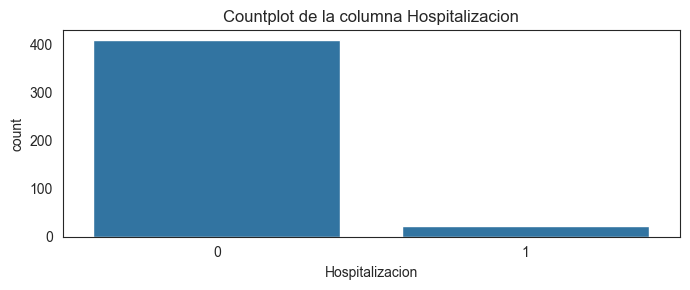

Hospitalizacion
0    408
1     23
Name: count, dtype: int64

In [9]:
countplot_vertical(df, 'Hospitalizacion')
df['Hospitalizacion'].value_counts()

Se observa un gran desbalaceo de las clases para la variable objetivo, siendo la clase positiva para la hospitalización solo 23 registros. Por tal motivo, se decide hacer un sobremuestreo de la variable.

---------------------

## Separación de los conjuntos de entrenamiento/testeo y sobremuestreo

Dado que se observa un gran desbalance de la variable objetivo, se decide hacer el sobremuestreo de la clase minoritaria de la misma utilizando el método `RandomOverSampler` de la librería `imbalanced-learn`. 

Por otra parte, este sobremuestreo se aplica sólo a los datos del entrenamiento (train), porque el objetivo es generar instancias sintéticas de la clase minoritaria para equilibrar la distribución de clases y mejorar el rendimiento del modelo en la detección de la clase minoritaria, pero se busca que el modelo sea capaz de generalizar sobre datos reales (test). De esta manera, se preservan datos para una evaluación realista y se evitan fugas de información al conjunto de entrenamiento, enfrentando al modelo a datos realmente nuevos.

In [11]:
# Se definen X e y (variables predictoras y variable objetivo)
X = df.drop('Hospitalizacion', axis=1)
y = df['Hospitalizacion']

# Se divide el conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f'Para el entrenamiento quedan {y_train.value_counts()[0]} etiquetas NO y {y_train.value_counts()[1]} etiquetas SI')
print(f'Para el testeo quedan {y_test.value_counts()[0]} etiquetas NO y {y_test.value_counts()[1]} etiquetas SI')

Para el entrenamiento quedan 285 etiquetas NO y 16 etiquetas SI
Para el testeo quedan 123 etiquetas NO y 7 etiquetas SI


In [12]:
# Se crea una instancia de RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Se aplica el sobremuestreo a los datos de entrenamiento
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

print(f'Para el entrenamiento quedan {y_train_ros.value_counts()[0]} etiquetas NO y {y_train_ros.value_counts()[1]} etiquetas SI')

Para el entrenamiento quedan 285 etiquetas NO y 285 etiquetas SI


----------------

# Estrategias de modelado

Como se describió al comienzo, se probaron dos estrategias para encontrar el mejor modelo que puediera considerar todas las variables que se tienen. En primer lugar, se enalizan todas las variables del conjunto de datos y luego se hace una reducción de la dimensionalidad.

## Todas las variables predictoras

Se decidió utilizar tres algoritmos de clasificación: K-Vecinos Cercanos (KNN), Árbol de Decisión (TREE) y Máquina de Soporte de Vectores (SVC). Para cada uno de ellos, se planteó la búsqueda de los mejores hiperparámetros a través de la búsqueda exaustiva de la combinación de rangos de valores para los hiperparámetros considerandos. Esto es lo que se llama Grid Search (búsqueda de grilla).

### Se define la grilla de hiperparámetros

En primer lugar se define una grilla de los hiperparámetros con los que se quiere probar cada modelo. A continuación, se instancia cada modelo y se hace el entrenamiento de cada combicación de hiperparámetro y modelo considerando una validación cruzada de 5 folds cada vez. Los resultados de las mejores métricas para cada modelo se guardan en una lista que permitirá luego comparar y graficar las matrices de confusión de cada una, para evaluar sus rendimientos.

In [13]:
# Define el rango de hiperparámetros para KNN el GridSearch
param_grid_knn = {
    'n_neighbors': np.arange(1, 20),
    'weights': ['uniform', 'distance'],
    'leaf_size':[1,3,5,7,10],
    'algorithm':['auto', 'kd_tree']
}

# Define el rango de hiperparámetros para tre el GridSearch
param_grid_tree = {
    "criterion": ['gini', 'entropy'],
    "max_depth": range(1, 20)
}

# Define el rango de hiperparámetros para SVC el GridSearch
param_grid_SVC = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

### Se hace el entrenamiento

In [21]:
def train_and_evaluate_model_estrategia1(estimador, param_grid_clf, X_train_ros, y_train_ros, X_test, y_test):
    '''
    Realiza el entrenamiento para los distintos modelos así como calcular las distintas métricas.
    También calcula la matriz de correlación para el entrenamiento y testeo y devuelve los mejores parámetros.
    '''
    # Crea una instancia de GridSearchCV
    grid_search = GridSearchCV(estimator=estimador, param_grid=param_grid_clf, cv=5)

    # Ajusta el GridSearch al conjunto de datos sobremuestreado
    grid_search.fit(X_train_ros, y_train_ros)

    # Obtiene el mejor modelo y sus hiperparámetros
    best_estimador = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Evalúa el modelo en el conjunto de prueba
    y_pred_test = best_estimador.predict(X_test)
    y_pred_train = best_estimador.predict(X_train_ros)
    
    # Calcula las matrices de confusión
    cm_train = confusion_matrix(y_train_ros, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    # Calcular las métricas que necesitas para entrenamiento y prueba
    train_accuracy = accuracy_score(y_train_ros, y_pred_train)
    train_precision = precision_score(y_train_ros, y_pred_train)
    train_recall = recall_score(y_train_ros, y_pred_train)
    train_f1 = f1_score(y_train_ros, y_pred_train)

    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    
    # Devolver las métricas en un diccionario
    metrics = {
        'Train Accuracy': train_accuracy,
        'Train Precision': train_precision,
        'Train Recall': train_recall,
        'Train F1': train_f1,
        'Test Accuracy': test_accuracy,
        'Test Precision': test_precision,
        'Test Recall': test_recall,
        'Test F1': test_f1,
    }
        
    return metrics, cm_train, cm_test, best_params


In [22]:
# Se crea una lista para almacenar los resultados de diferentes modelos
results = []

# Se instancia y evalua el modelo K-NN
knn = KNeighborsClassifier()
knn_metrics, knn_cm_train, knn_cm_test, knn_best_params = train_and_evaluate_model_estrategia1(knn, param_grid_knn, X_train_ros, y_train_ros, X_test, y_test)
results.append(('KNN', knn_metrics))

# Instanciar y evaluar el modelo Decision Tree
tree = DecisionTreeClassifier()
tree_metrics, tree_cm_train, tree_cm_test, tree_best_params = train_and_evaluate_model_estrategia1(tree, param_grid_tree, X_train_ros, y_train_ros, X_test, y_test)
results.append(('Decision Tree', tree_metrics))

# Instanciar y evaluar el modelo SVC
svc = SVC(probability=True)
svc_metrics, svc_cm_train, svc_cm_test, svc_best_params = train_and_evaluate_model_estrategia1(svc, param_grid_SVC, X_train_ros, y_train_ros, X_test, y_test)
results.append(('SVC', svc_metrics))

## Resultado

In [23]:
def summary_results_estrtegia1(results):
    '''
    Devuelve un resumen de las métricas a partir de un diccionario que contiene el resumen.
    '''
    # Convertir la lista de resultados en un DataFrame
    data = []

    for model_name, metrics in results:
        metrics['Model'] = model_name
        data.append(metrics)

    df_summary = pd.DataFrame(data)

    # Reordenar las columnas para tener un formato más legible
    columns = ['Model', 'Train Accuracy', 'Train Precision', 'Train Recall', 'Train F1', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1']
    df_summary = df_summary[columns]
    return df_summary

In [24]:
# Se presenta un resumen de las mejores métricas para cada modelo
summary_results_estrtegia1(results)

,Model,Train Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
0,KNN,1.0,1.0,1.0,1.0,0.961538,0.666667,0.571429,0.615385
1,Decision Tree,1.0,1.0,1.0,1.0,0.969231,0.800000,0.571429,0.666667
2,SVC,1.0,1.0,1.0,1.0,0.953846,1.000000,0.142857,0.250000


In [25]:
# Se presentan los mejores parámetros para cada modelo
print('PARÁMETROS DE LOS MEJORES MODELOS')
print('KNN:', knn_best_params)
print('Decision Tree:', tree_best_params)
print('SCV:', svc_best_params)

PARÁMETROS DE LOS MEJORES MODELOS
KNN: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': np.int64(2), 'weights': 'uniform'}
Decision Tree: {'criterion': 'gini', 'max_depth': 18}
SCV: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


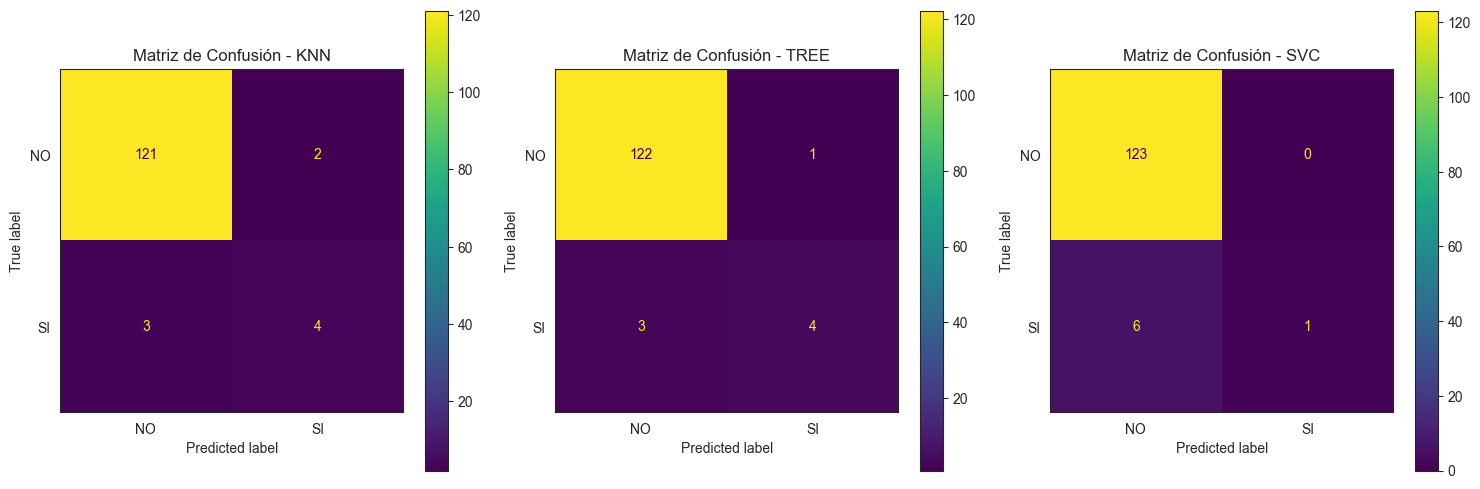

In [26]:
# Se visualizan las tres matrices de confusión
matrices = [knn_cm_test, tree_cm_test, svc_cm_test]
modelos = ['KNN', 'TREE', 'SVC']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, m in enumerate(matrices):
    ax = axes[i]
    cm_display = ConfusionMatrixDisplay(m, display_labels=['NO', 'SI'])
    cm_display.plot(ax=ax)
    ax.set_title(f'Matriz de Confusión - {modelos[i]}')

plt.tight_layout()
plt.show()

Al ser un conjunto de datos con un gran desbalanceo en la variable objetivo, se toma como métrica de evaluación F1 Score (Test_F1) dado que combina la precisión (resultados correctos sobre el total de muestras seleccionadas) y la exhaustividad (resultados correctos por sobre los resultados que se buscan identificar) de manera de mantener una relación entre las dos. Para esta métrica, **Árbol de Decisión** es el que dió un mejor F1, pero es de 0.67, aún tiene un margen grande de error en las predicciones de los que sí serán hospitalizados, tal como se visualiza en las matrices de confusión.

----------------

## Usando reducción de dimensionalidad (PCA)

Para estas segunda estrategia, se consideran analizar los mismos modelos bajo los escenarios de reducir la dimensionalidad del conjunto de datos a diferentes cantidades de componentes.

En primer lugar se estandarizan los datos utilizando `StandardScaler` que normaliza las variables numéricas en una distribución normal de media de 0 y desviación estandar de 1. A continuación, se definen 4 escenarios teneniendo en cuenta 3, 5, 8 y 10 componentes a los cuales se reducirán las variables y mediante un ciclo iterativo se reducen la dimensionalidad y entrenan cada uno de los modelos.

Las mejores métricas de cada modelo para cada escenario de PCA se guarda en un diccionario para luego comparar y visualizar.

### Se preparan los datos

In [27]:
# Se estandarizan los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_ros)
X_test_scaled = scaler.transform(X_test)

### Se hace el entrenamiento

In [28]:
def GridSearch_model(model, param_grid, X_train, y_train, X_test, y_test):
    '''
    Entrena un modelo haciendo la técnica de búsqueda de hiperparámetros en grilla y devuelve
    los valores de y predichos para el entrenamiento y testeo, asó como el mejor modelo y sus parámetros.
    '''
    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    best_params = grid_search.best_params_
    
    return y_pred_train, y_pred_test, best_model, best_params

In [29]:
# Se define un diccionario para almacenar resultados
results = {}

# Se definen los números de componentes principales
num_components = [3, 5, 8, 10]

for n in num_components:
    
    # Se aplica PCA
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # Se hace el entrenamiento y evaluación de los modelos
    knn_pred_train, knn_pred_test, best_knn, knn_best_params = GridSearch_model(knn, param_grid_knn, X_train_pca, y_train_ros, X_test_pca, y_test)
    tree_pred_train, tree_pred_test, best_tree, tree_best_params = GridSearch_model(tree, param_grid_tree, X_train_pca, y_train_ros, X_test_pca, y_test)
    svc_pred_train, svc_pred_test, best_svc, svc_best_params = GridSearch_model(svc, param_grid_SVC, X_train_pca, y_train_ros, X_test_pca, y_test)
    
    # Se almacenan los resultados en el diccionario
    results[n] = {
        'KNN': (knn_pred_train, knn_pred_test, best_knn),
        'Tree': (tree_pred_train, tree_pred_test, best_tree),
        'SVC': (svc_pred_train, svc_pred_test, best_svc)
    }

### Resultados

In [33]:
def resumen_metricas_PCA(results, y_train_ros, y_test_ros):
    '''
    Permite resumir las mejores métricas para los distintos modelos, tanto para el entrenaiento como el testeo.
    '''
    # Crear una lista de diccionarios para almacenar los resultados
    summary_results = []

    # Resumir métricas de forma más concisa y almacenar en la lista
    for n, models in results.items():
        for model_name, (y_train_pred, y_test_pred, best_model) in models.items():
            report_train = classification_report(y_train_ros, y_train_pred, output_dict=True)
            report_test = classification_report(y_test_ros, y_test_pred, output_dict=True)
            
            summary_results.append({
                'Components': n,
                'Model': model_name,
                'Train_Precision': report_train["macro avg"]["precision"],
                'Train_Recall': report_train["macro avg"]["recall"],
                'Train_F1': report_train["macro avg"]["f1-score"],
                'Test_Precision': report_test["macro avg"]["precision"],
                'Test_Recall': report_test["macro avg"]["recall"],
                'Test_F1': report_test["macro avg"]["f1-score"]
            })

    # Crear un DataFrame a partir de la lista de resultados
    df_summary = pd.DataFrame(summary_results)

    # Reorganizar el DataFrame para tener una columna para cada métrica
    df_summary_metrics = df_summary.pivot(index='Components', columns='Model')

    # Elegir las métricas que deseas visualizar (por ejemplo, precisión, recall, F1-score)
    metrics_to_show = ['Train_Precision', 'Train_Recall', 'Train_F1', 'Test_Precision', 'Test_Recall', 'Test_F1']
    df_metrics_to_show = df_summary_metrics[metrics_to_show]

    # Crear un heatmap
    plt.figure(figsize=(10, 3))
    sns.heatmap(df_metrics_to_show, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Comparación de Métricas por Modelo y Componentes Principales')
    plt.show()
    
    return df_summary

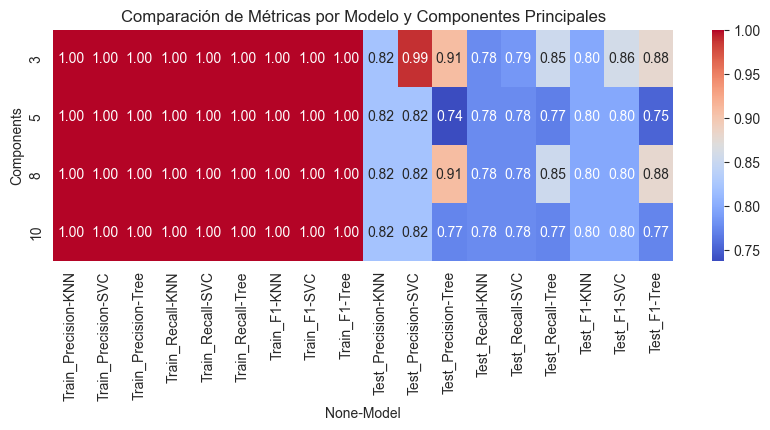

In [34]:
# Se resumen las métricas
df_summary = resumen_metricas_PCA(results, y_train_ros, y_test)

In [36]:
def matriz_confusion_PCA(df_summary, results, y_test, metrica):
    '''
    Realiza la matriz de confusión para el mejor modelo y mejor métrica que se obtuvo para el enfoque de PCA.
    '''
    # df_summary contiene la información de los mejores modelos
    best_model_info = df_summary[df_summary[metrica] == df_summary[metrica].max()].iloc[0]

    # Obtener información del mejor modelo
    best_components = best_model_info['Components']
    best_model_name = best_model_info['Model']

    # Obtener predicciones del mejor modelo
    best_model_preds = results[best_components][best_model_name][1]

    # Obtener matriz de confusión
    conf_matrix = confusion_matrix(y_test, best_model_preds)

    # Crear una visualización de la matriz de confusión
    cm_display = ConfusionMatrixDisplay(conf_matrix)
    cm_display.plot()
    plt.xlabel('Predicciones')
    plt.ylabel('Verdaderos')
    plt.title(f'Confusion Matrix for {best_model_name} (Components: {best_components})')
    plt.show()

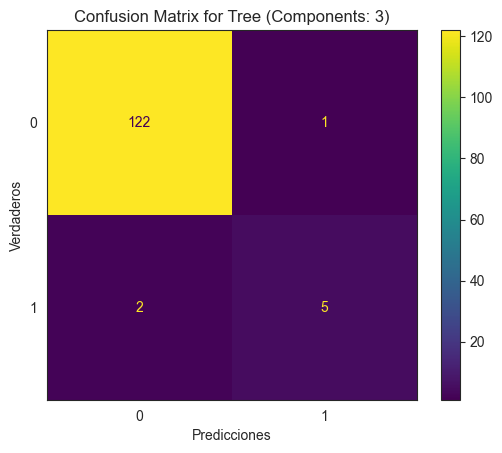

In [37]:
# Visualiza la matriz de confusión para la metrica deseada
matriz_confusion_PCA(df_summary, results, y_test, 'Test_F1')

In [38]:
# Se presentan los mejores parámetros para cada modelo
print('PARÁMETROS DE LOS MEJORES MODELOS')
print('KNN:', knn_best_params)
print('Decision Tree:', tree_best_params)
print('SCV:', svc_best_params)

PARÁMETROS DE LOS MEJORES MODELOS
KNN: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': np.int64(1), 'weights': 'uniform'}
Decision Tree: {'criterion': 'entropy', 'max_depth': 17}
SCV: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


En este enfoque, se puede ver que el modelo que da mejores resultados es **Árbol de Decisión** para el escenario de 8 componentes de reducción de dimensionalidad. Para este caso se ve que F1 Score es de 0.92, mucho mejor que el obtenido con el primer enfoque.

-----------------
----------------

# Conclusiones

Se entrenaron 3 modelos (Árbol de Decisión, K-Vecinos Cercanos y Máquina de Soporte de Vectores) teniendo en cuenta dos enfoques de análisis. Por un lado teniendo en cuenta todas las variables del conjunto de datos y, por otro lado, considerando cuatro escenarios de reducción de dimensionalidad del conjunto.

En ambos enfoques se encontró que el mejor algoritmo que clasifica los pacientes en los que se hospitalizados y no hospitalizados fue el Árbol de Decisión, pero en el caso del primer enfoque, donde se usaron todas las variables del conjunto de datos, solo llegó a un F1 Score de 0.67, bastante bajo. Sin embago, con el enfoque de reducción de la dimensionalidad, el mejor modelo fue un Árbol de decisión de máxima profundidad de 19, con criterio Gini y con 8 Componentes de reducción. En éste último caso, se llegó a un F1 Score de 0.92, siendo un muy buen rendimiento considerando el gran desbalance de la clase objetivo.